<a href="https://colab.research.google.com/github/RaiShra1/Computer-Vision-and-Image-Processing/blob/main/Homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#downgrade opencv to accomodate SIFT
! pip install opencv-python==3.4.2.17
! pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 97kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import files
uploaded = files.upload()

Saving keble_a.jpg to keble_a.jpg
Saving keble_b.jpg to keble_b.jpg
Saving keble_c.jpg to keble_c.jpg


In [82]:
import numpy as np
import cv2
import scipy
from scipy import ndimage, spatial
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import math
import random


In [150]:
#load all the images
image1 = cv2.imread('/content/keble_a.jpg')
image2 = cv2.imread('/content/keble_b.jpg')
image3 = cv2.imread('/content/keble_c.jpg')

In [151]:
def featureDetector(image):
  # convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  descriptor = cv2.xfeatures2d.SIFT_create()
  # detect and extract features from the image
  (kps, features) = descriptor.detectAndCompute(image, None)
  # return a tuple of keypoints and features
  return (kps, features)

In [152]:
kps1,features1 = featureDetector(image1)
kps2,features2 = featureDetector(image2)
kps3,features3 = featureDetector(image3)

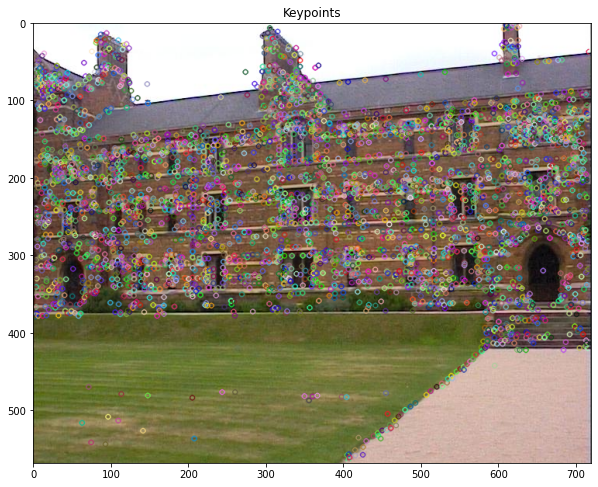

In [153]:
 image1features = np.zeros_like(image1)
 cv2.drawKeypoints(image1, kps1, image1features)
 plt.figure(figsize=(10,10))
 plt.title("Keypoints")
 plt.imshow(cv2.cvtColor(image1features, cv2.COLOR_BGR2RGB))
 plt.show()

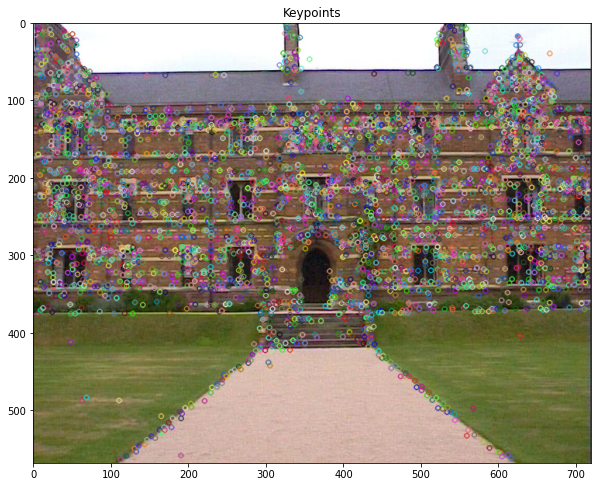

In [154]:
 image2features = np.zeros_like(image2)
 cv2.drawKeypoints(image2, kps2, image2features)
 plt.figure(figsize=(10,10))
 plt.title("Keypoints")
 plt.imshow(cv2.cvtColor(image2features, cv2.COLOR_BGR2RGB))
 plt.show()

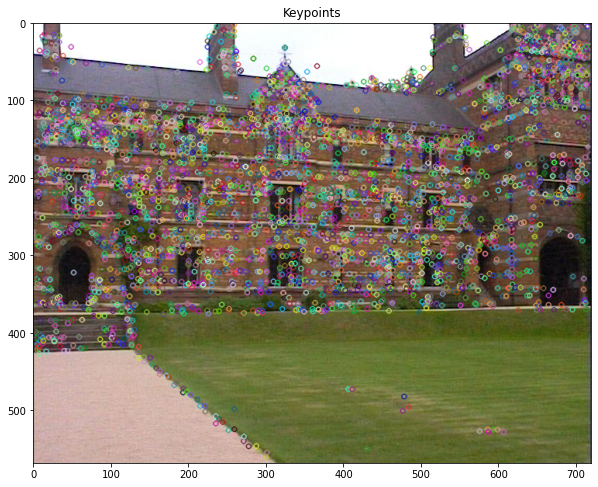

In [155]:
 image3features = np.zeros_like(image3)
 cv2.drawKeypoints(image3, kps3, image3features)
 plt.figure(figsize=(10,10))
 plt.title("Keypoints")
 plt.imshow(cv2.cvtColor(image3features, cv2.COLOR_BGR2RGB))
 plt.show()

In [156]:
def matchfeatures(a,keypointlength,threshold):
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia,
    #take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0] # min 
    minval2=x[1] # 2nd min
    itemindex1 = listx.index(minval1) #index of min val    
    itemindex2 = listx.index(minval2) #index of second min value 
    ratio=minval1/minval2         #Perform ratio test: d(fa, fb1) / d(fa, fb2) 
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i])for i in range(0,index)]


In [157]:
# Euclidean distance to compute pairwise distances between the SIFT descriptors
# of refernce image and right image
p1= scipy.spatial.distance.cdist(features3,features2,metric="sqeuclidean")

In [158]:
feature_matches1=matchfeatures(p1,4000,0.2)
print("Number of Matches", len(feature_matches1))

Number of Matches 372


In [159]:
showmatches1 = cv2.drawMatches(image3, kps3,image2, kps2, feature_matches1,\
                              None, flags=2)

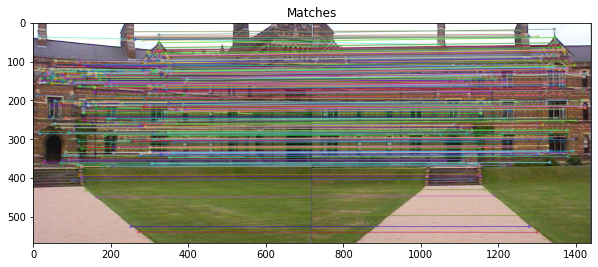

In [161]:
plt.figure(figsize=(10,10))
plt.title("Matches")
plt.imshow(cv2.cvtColor(showmatches1, cv2.COLOR_BGR2RGB))
plt.show()

In [162]:
# Euclidean distance to compute pairwise distances between the SIFT descriptors
# of refernce image and right image
p2 = scipy.spatial.distance.cdist(features1,features2,metric="sqeuclidean")
feature_matches2=matchfeatures(p2,4000,0.2)
print("Number of Matches", len(feature_matches2))

Number of Matches 362


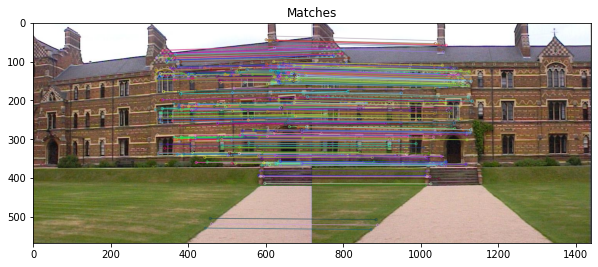

In [163]:
showmatches2 = cv2.drawMatches(image1, kps1,image2, kps2, feature_matches2,\
                              None, flags=2)
plt.figure(figsize=(10,10))
plt.title("Matches")
plt.imshow(cv2.cvtColor(showmatches2, cv2.COLOR_BGR2RGB))
plt.show()

Calculate Homogrpahy

In [164]:
def computeH(im1_pts,im2_pts):
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix, which
  # will correspond to the smallest singular value, and thus the least error
  return H

In [165]:
#Estimate Homography between the right and center image
im3_pts=np.empty((len(feature_matches1),2))
im2_pts=np.empty((len(feature_matches1),2))
for i in range(0,len(feature_matches1)):
  m = feature_matches1[i]
  (a_x, a_y) = kps3[m.queryIdx].pt
  (b_x, b_y) = kps2[m.trainIdx].pt
  im3_pts[i]=(a_x, a_y)
  im2_pts[i]=(b_x, b_y)    
H=computeH(im3_pts,im2_pts)

Function for RANSAC

In [167]:
#helper function for RANSAC
def GetInliers(f1, f2, feature_matches, H,  thresh):
  inlier_indices = []
  for i in range(len(feature_matches)):
    queryInd = feature_matches[i].queryIdx
    trainInd = feature_matches[i].trainIdx

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    transformedQueryFeature = H.dot(queryPoint) 

   
    comp1 = [transformedQueryFeature[0]/transformedQueryFeature[2],\
             transformedQueryFeature[1]/transformedQueryFeature[2]] 
             # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= thresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices

In [168]:
def funcRANSAC(f1, f2, feature_matches, iters, thresh):      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(iters):
        #Choose a minimal set of feature matches.
        matchSample = random.sample(feature_matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
  
        H_estimate=computeH(im1_pts,im2_pts)      
        # Calculate the inliers for the H
        inliers = GetInliers(f1, f2, feature_matches, H_estimate, thresh)

        # if the number of inliers is higher than previous
        # iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(feature_matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      
    M=computeH(im1_pts,im2_pts)
    return M

In [169]:
#Calculate the Homogrpahy by applying RANSAC
H1=funcRANSAC(kps3, kps2, feature_matches1,100,0.4)    
global inlier_matchset   
drawRANSACMatch=cv2.drawMatches(image3,kps3,image2,kps2,inlier_matchset,\
                                None,flags=2)

Number of best inliers 152


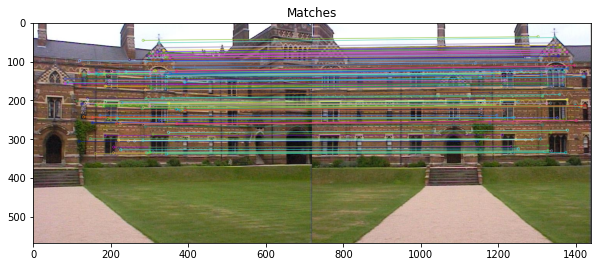

In [170]:
plt.figure(figsize=(10,10))
plt.title("Matches")
plt.imshow(cv2.cvtColor(drawRANSACMatch, cv2.COLOR_BGR2RGB))
plt.show()

In [171]:
#Estimate Homography between the left and center image
im1_pts=np.empty((len(feature_matches2),2))
im2_pts=np.empty((len(feature_matches2),2))
for i in range(0,len(feature_matches2)):
  m = feature_matches2[i]
  (a_x, a_y) = kps1[m.queryIdx].pt
  (b_x, b_y) = kps2[m.trainIdx].pt
  im1_pts[i]=(a_x, a_y)
  im2_pts[i]=(b_x, b_y)    
H=computeH(im1_pts,im2_pts)

#RANSAC
H2=funcRANSAC(kps1, kps2, feature_matches2,100,0.4)    
global inlier_matchset   
drawRANSACMatch2=cv2.drawMatches(image1,kps1,image2,kps2,inlier_matchset,\
                                None,flags=2)

Number of best inliers 162


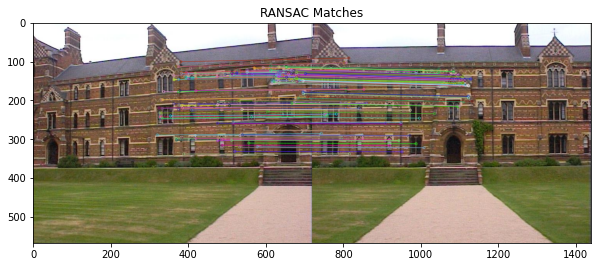

In [172]:
plt.figure(figsize=(10,10))
plt.title("RANSAC Matches")
plt.imshow(cv2.cvtColor(drawRANSACMatch2, cv2.COLOR_BGR2RGB))
plt.show()

In [173]:
H1 = H1/H1[2,2]
H2 = H2/H2[2,2]

In [174]:
#function to give box bounding the image by taking the image and the Homography 
#and applying the H transformation in the image
def ImageBounds(img, H):
    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    min_x = math.ceil(min(x1, x2, x3, x4))
    min_y = math.ceil(min(y1, y2, y3, y4))
    max_x = math.ceil(max(x1, x2, x3, x4))
    max_y = math.ceil(max(y1, y2, y3, y4))

    return int(min_x), int(min_y), int(max_x), int(max_y)

In [175]:
import sys

In [176]:
class ImageData:
  def __init__(self, img, transform):
    self.img = img 
    self.transform = transform


In [177]:
min_x = sys.maxsize
min_y = sys.maxsize
max_x = 0
max_y =0 

M = np.identity(3)

img_data1 = ImageData(image1, H2)
img_data2 = ImageData(image2, np.eye(3))
img_data3 = ImageData(image3, H1)

img_data = [img_data1, img_data2, img_data3]

for i in img_data:
  M = i.transform
  img = i.img
  xmin, ymin, xmax, ymax = ImageBounds(img, M)
  min_x = min(min_x, xmin)
  min_y = min(min_y, ymin)
  max_x = max(max_x, xmax)
  max_y = max(max_y, ymax)

stitchedImgWidth = int(math.ceil(max_x)-math.floor(min_x))
stitichedImgHeight = int(math.ceil(max_y)- math.floor(min_y))


In [178]:
#helper function for Stitch
def accumulate(img, accumulator, H, bw):
    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2]\
             == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt

In [179]:
#function to stitch the three images
def Stitch(img_data, blendWidth, s_width, s_height, translation):
    channels=3
    width=720

    acc = np.zeros((s_height, s_width, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(img_data):
        M = i.transform
        img = i.img
        M_trans = translation.dot(M)
        accumulate(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(img_data):
        if count != 0 and count != (len(img_data) - 1):
            continue

        M = i.transform

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(img_data) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (s_width, s_height), flags=cv2.INTER_LINEAR
    )

    return croppedImage

In [180]:
translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

In [181]:
stitchedImage = Stitch(img_data,1000, stitchedImgWidth,\
                       stitichedImgHeight, translation)

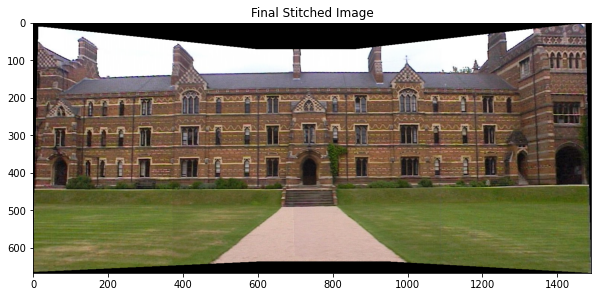

In [182]:
plt.figure(figsize=(10,10))
plt.title("Final Stitched Image")
plt.imshow(cv2.cvtColor(stitchedImage, cv2.COLOR_BGR2RGB))
plt.show()